###  Libraries

In [2]:
import scipy.io
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Datasets.Datasets_Functions import *
from Rings import Rings
from Common_Modules.Evaluation import Evaluator
from Common_Modules.Graph import Graph
from Common_Modules.Visualization import Visualization
from Common_Modules.General_Functions import General_Functions

### Switches

In [2]:
plot_is_enabled = False
two_rings_is_enabled = False
three_rings_is_enabled = False
one_ring_with_two_gaussians_is_enabled = False
three_rings_paper_is_enabled = False
graph_is_enabled = False
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = False
globalKernelKMeans_is_enabled = False
globalKernelKMeansPP_is_enabled = False

### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()
n_candidates = n_init = 100
kernel = 'laplacian'
gamma = 1.0

### Visualization

In [4]:
visualization = Visualization()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

### Load Dataset

### 2Rings

In [4]:
if(two_rings_is_enabled):
    # centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]
    centers_coordinates = [(-1, 2), (2, 2)]
    rings = Rings(colors=colors)
    
    X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)
    rings.plot(X, y)
    
    K = 2 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### 3Rings

In [5]:
if (three_rings_is_enabled):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    rings = Rings(colors=colors)

    # Define the center for the single set of three concentric rings
    centers_coordinates = [(0, 0)]

    # Generate and plot the rings
    X, y = rings.make_concentric_rings(centers_coordinates=centers_coordinates, n_samples=150, radii=[1, 10, 25], noise=0)
    rings.plot(X, y)
    
    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='sigmoid')

### 1 Ring with 2 Gaussians Inside

In [6]:
if(one_ring_with_two_gaussians_is_enabled):
    # Usage example
    colors = ['purple', 'orange', 'blue', 'red', 'green', 'lime']
    
    rings = Rings(colors)
    centers_coordinates = [(5, 5), (-5, 5)]
    X, y = rings.make_multiple_rings_with_gaussians(centers_coordinates, n_samples=100, radius=3, noise=0.0, gaussian_samples=50)
    
    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=0.5)

### 3Rings Paper

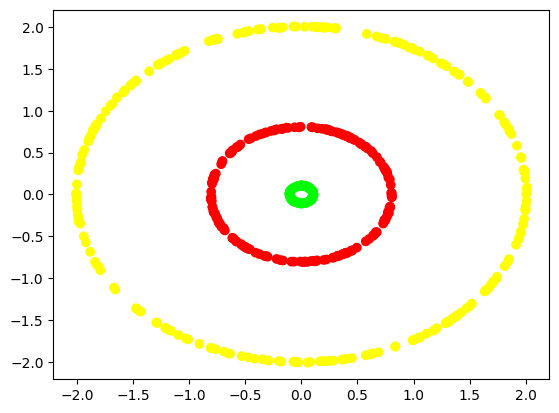

In [5]:
if (three_rings_paper_is_enabled):
    rings = Rings(colors=colors)
    X, y, kernel_matrix = rings.global_kernel_k_means_three_rings()
    K = 3

    rings.plot(X,y)

### Graphs

In [8]:
if(graph_is_enabled):
    # Number of nodes per community
    n_nodes_per_community = 10

    # Number of communities
    K = n_communities = 10
    
    # Probability of intra-community edge
    p_intra = 1  
    
    # Probability of inter-community edge
    p_inter = 0.01  

    graph = Graph(n_communities, n_nodes_per_community, p_intra, p_inter, colors)
    graph.create_adj_matrix()
    kernel_matrix = graph.adj_matrix = pairwise_kernels(graph.adj_matrix, graph.adj_matrix, metric='linear')
    graph.create_kernel_matrix_from_adj_matrix()

### Real Dataset

In [ ]:
dataset_name = "wine" # The available datasets are: breast_cancer, dermatology, ecoli, iris, olivetti_faces, pendigits, waveform_v1, wine
module_name = "Datasets.Datasets"
batch_size = 16
dataloader, input_dim, X, y = function_get_dataset(dataset_name, module_name, batch_size)
print('Date Number is:', len(y))
print('Data_Shape is:', input_dim)
K = len(np.unique(y))
kernel_matrix = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
data_dir_path = f"Results\\{dataset_name}\\{kernel}\\{n_init}\\"
General_Functions().create_directory(data_dir_path)
K = 50

### kMeans

In [10]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    if(plot_is_enabled):
        visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans

In [11]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    if(plot_is_enabled):
        visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans++

In [12]:
if(kernelKMeansPP_is_enabled):
    initialization_methods = ["forgy", "random", "k-means++"]
    n_iters_ = {}
    execution_times_ = {}
    inertias_ = {}
    init = initialization_methods[2]
    prev_K = K
    K = 2
    while (K != prev_K + 1):
        kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=n_init, init=init, verbose=0)
        kernelKMeans.fit()
        
        if(plot_is_enabled):
            if graph_is_enabled:
                graph.plot_clusters(kernelKMeans.labels_)
            else:
                visualization.plot_tsne(X, y, data_dir_path=data_dir_path + "KernelKMeans_" + init)                
        
        n_iters_[K] = sum(kernelKMeans.n_iters_.values())
        execution_times_[K] = sum(kernelKMeans.execution_times_.values())
        inertias_[K] = kernelKMeans.inertia_
        new_row = { "K": K, "MSE": inertias_[K], "ITERATIONS": n_iters_[K], "EXECUTION TIME": execution_times_[K]}
        General_Functions.append_to_csv(f"{data_dir_path}KernelKMeans_Dataset_{dataset_name}_Init_{init}_Kernel_{kernel}_K_{prev_K}_Inits_{n_init}_Results.csv", new_row)
        K += 1
    K = prev_K   

### Global Kernel kMeans

In [13]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeans.fit()
    
    if(plot_is_enabled):
        if graph_is_enabled:
            graph.plot_clusters(globalKernelKMeans.labels_[K])
        else:
            visualization.plot_tsne(X, y, data_dir_path=f"{data_dir_path}GlobalKernelKMeans")

### Global Kernel kMeans++

In [14]:
if(globalKernelKMeansPP_is_enabled):
    sampling_methods = ["sequential", "batch"]
    sampling = sampling_methods[0] 
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=n_candidates, sampling=sampling, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Sampling_{sampling}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeansPP.fit()
    
    acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
    if(plot_is_enabled):
        if graph_is_enabled:
            graph.plot_clusters(globalKernelKMeansPP.labels_[K])
        else:
            visualization.plot_tsne(X, y, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_{sampling}_")